In [1]:
import os,random,itertools,matplotlib
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
# Umitools
from umi_tools._dedup_umi import edit_distance
matplotlib.rcParams['font.family'] = 'Helvetica'

def str2array(s):
    a,b= s.split('\t')[:2]
    return (a,int(b))

def merge_edit_1(counts):
    keep,collapse = [],counts[0:]
    while len(collapse)>0:
        ref = list(collapse[0]) # need to convert to list here otherwise will keep updating the value to new_cluster
        temp = []
        for s in collapse[1:]:
            s1 = ref[0]
            s2 = s[0]
            if abs(len(s1)-len(s2))<=1 and edit_distance(s1.encode('utf-8'),s2.encode('utf-8'))<2:
                ref[-1] += s[-1]
            else:
                temp.append(s)
        keep.append(ref)
        collapse = temp[0:]
    return np.array(keep,dtype=object)

def reverse_complement(seq):
    """This function returns the reverse_complement sequence of the input sequence
    from 3' to 5' """
    complement = {'A':'T', 'C':'G','G':'C', 'T':'A', 'N':'N'}
    rcomp_seq = ''
    for base in seq:
        rcomp_seq = complement[base] + rcomp_seq   
    return rcomp_seq
%matplotlib inline


# FigureS3 a-b 4 enhancer MPRA vs ENGRAM

In [2]:
path = '../Figure2/4_enhancer_mix/'
samples =sorted([s.split('_bc_count.tsv')[0] for s in os.listdir(path) if '.tsv' in s ])
bc_ref = pd.read_table(path+'enhancer_ref.txt',header=None,names=['enhancer','barcode','ES'])
edits = []
df_stack = pd.DataFrame(columns=['enhancer','ratio','rep','sample'])
for s in samples:
    file = path+s
    #rcount = int(read_count[read_count['sample'].str.contains(s)]['counts'])
    with open(file +'_bc_count.tsv','r') as f:
        temp = f.readlines()
        count_table = np.array([a for a in merge_edit_1([a for a in [str2array(s) for s in temp] if a[0]=='' or len(a[0])==5]) if a[1]>10])
        ratio = sum(count_table[1:,1])/sum(count_table[:,1])
    f.close()
    df = pd.DataFrame([count_table[1:,0],count_table[1:,1]/sum(count_table[:,1])*100]).T.merge(bc_ref,left_on=0,right_on='barcode',how='right')
    #df[1] = df[1]/df['ES'].rpow(2)
    df = df.groupby(df['enhancer'],as_index=False).aggregate({1: 'sum',})
    df['rep'] = s.split("_")[-1]
    df['sample'] = 'Bm'
    df.columns = ['enhancer','ratio','rep','sample']
    x= df[df['enhancer']=='Active']['ratio'].sum()/df[df['enhancer']!='Active']['ratio'].sum()
    print (100/(x+1)*x)
    df_stack = pd.concat((df_stack,df))
    #df['barcode'] = df[0].apply(reverse_complement)
df_stack = df_stack.reset_index(drop=True)

89.59003215434085
88.41262364578427
86.3926576217079


In [3]:
df = pd.DataFrame([count_table[1:,0],count_table[1:,1]/sum(count_table[:,1])*100]).T.merge(bc_ref,left_on=0,right_on='barcode',how='right')

In [4]:
print (df_stack[df_stack['enhancer']=='Active']['ratio'].mean()/df_stack[df_stack['enhancer']=='Inactive']['ratio'].mean(),\
       sp.stats.ttest_ind(list(df_stack[df_stack['enhancer']=='Active']['ratio']),list(df_stack[df_stack['enhancer']=='Inactive']['ratio']), 
                      equal_var=True)[1])
print (df_stack[df_stack['enhancer']=='Active']['ratio'].mean()/df_stack[df_stack['enhancer']=='minP']['ratio'].mean(),\
       sp.stats.ttest_ind(list(df_stack[df_stack['enhancer']=='Active']['ratio']),list(df_stack[df_stack['enhancer']=='minP']['ratio']), 
                      equal_var=True)[1])
print (df_stack[df_stack['enhancer']=='Active']['ratio'].mean()/df_stack[df_stack['enhancer']=='Pless']['ratio'].mean(),\
       sp.stats.ttest_ind(list(df_stack[df_stack['enhancer']=='Active']['ratio']),list(df_stack[df_stack['enhancer']=='Pless']['ratio']), 
                      equal_var=True)[1])

15.062568073690352 0.00037536649916417676
23.6422411098034 0.0003373853761871422
41.31212534758922 0.0003136308260921942


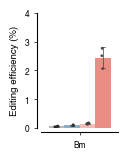

In [6]:
fig, axs = plt.subplots(figsize=(1,1.5),sharey=False,sharex=False)
g=sns.barplot(data=df_stack, x="sample", y='ratio', hue="enhancer",\
            palette=['#B7B7B7','#80B1D3','#FFB4AC','#FB8072'],hue_order=['Pless','minP','Inactive','Active'],errwidth=0.5, errorbar='sd', capsize=.06,ax=axs)
sns.stripplot(data=df_stack, x="sample", y='ratio',hue="enhancer",hue_order=['Pless','minP','Inactive','Active'], dodge=True,palette='dark:#4A4A4A',marker='.',size=4,ax=axs)

axs.set_xlabel('');
#g.set_box_aspect(6/len(g.patches))
axs.set_ylim(0,4)
start, end = axs.get_ylim()
axs.yaxis.set_ticks(np.arange(start, end+0.2, 1))
axs.set_ylabel('Editing efficiency (%)',fontsize=7)

axs.xaxis.set_tick_params(width=0.5, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.5, length=2,labelsize=6)
sns.despine(offset=3)
axs.legend([],[], frameon=False)
#plt.savefig('../Figure2/figs/Supp_4_enhancer_mix.pdf')

# Figure2 300 enhancer MPRA vs ENGRAM

## Compare endo and Synthetic TAPE efficiency

In [7]:
path = '../Figure2/300_enhancer/Hek3/'
endo_eff,syn_eff = [],[]

df_endo = pd.read_table('../Figure2/300_enhancer/Enhancer_designs.txt',header=0).iloc[:,2:]
samples =sorted([s.split('_S')[0] for s in os.listdir(path) if '.gz' in s and 'R1' in s and '16X' in s])
for i in range(3):
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==0 or len(a[0])==6]),columns=['barcode','count'])
        test['barcode'] = test['barcode']
        df_endo = df_endo.merge(test,on='barcode',how='inner').fillna(0)
        endo_eff.append((1-test.loc[0,'count']/test['count'].sum())*100)
    f.close()
df_endo.columns = ['barcode','RNA/DNA ratio','ins_rep1','ins_rep2','ins_rep3']
df_endo['ratio_rep1'] =  np.log2((df_endo['ins_rep1']+1)/(df_endo['ins_rep1'].sum()+1))#
df_endo['ratio_rep2'] =  np.log2((df_endo['ins_rep2']+1)/(df_endo['ins_rep2'].sum()+1))#*10**6
df_endo['ratio_rep3'] =  np.log2((df_endo['ins_rep3']+1)/(df_endo['ins_rep3'].sum()+1))#*10**6
df_endo['ratio_all'] = np.log2((df_endo['ins_rep1']+df_endo['ins_rep2']+df_endo['ins_rep3']+1)/
                          (df_endo['ins_rep1'].sum()+df_endo['ins_rep2'].sum()+df_endo['ins_rep3'].sum()+1))#*10**6

path = '../Figure2/300_enhancer/synHek3/'
df_syn = pd.read_table('../Figure2/300_enhancer/Enhancer_designs.txt',header=0).iloc[:,2:]
samples =sorted([s.split('_S')[0] for s in os.listdir(path) if '.gz' in s and 'R1' in s and '16X' in s])
for i in range(3):
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==0 or len(a[0])==6]),columns=['barcode','count'])
        test['barcode'] = test['barcode'].apply(reverse_complement)
        df_syn = df_syn.merge(test,on='barcode',how='inner').fillna(0)
        syn_eff.append((1-test.loc[0,'count']/test['count'].sum())*100)
    f.close()

df_syn.columns = ['barcode','RNA/DNA ratio','ins_rep1','ins_rep2','ins_rep3']
df_syn['ratio_rep1'] =  np.log2((df_syn['ins_rep1']+1)/(df_syn['ins_rep1'].sum()+1))#
df_syn['ratio_rep2'] =  np.log2((df_syn['ins_rep2']+1)/(df_syn['ins_rep2'].sum()+1))#*10**6
df_syn['ratio_rep3'] =  np.log2((df_syn['ins_rep3']+1)/(df_syn['ins_rep3'].sum()+1))#*10**6
df_syn['ratio_all'] = np.log2((df_syn['ins_rep1']+df_syn['ins_rep2']+df_syn['ins_rep3']+1)/
                          (df_syn['ins_rep1'].sum()+df_syn['ins_rep2'].sum()+df_syn['ins_rep3'].sum()+1))#*10**6

[Text(0, 0, 'synthetic'), Text(1, 0, 'endogenous')]

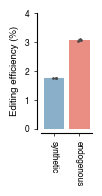

In [9]:
df = pd.DataFrame([['endogenous']*3+['synthetic']*3,['rep1','rep2','rep3']*2,endo_eff+syn_eff]).T
df.columns=['Designs','rep','Editing efficiency']
fig, axs = plt.subplots(figsize=(1.5,1.5),sharey=False,sharex=False)
g=sns.barplot(data=df, x="Designs", y='Editing efficiency', order=['synthetic','endogenous'],palette=['#80B1D3','#FB8072'],errwidth=0.5, errorbar='sd', capsize=.1) 
sns.stripplot(data=df, x="Designs", y='Editing efficiency',  order=['synthetic','endogenous'],dodge=True,color="#4A4A4A",marker='.',size=4,ax=axs)
sns.despine(offset=3)
axs.set_ylim(0,4)
start, end = axs.get_ylim()
axs.yaxis.set_ticks(np.arange(start, end+1, 1))
axs.set_xlabel('');
g.set_box_aspect(4.5/len(g.patches))
start, end = axs.get_ylim()
axs.set_ylabel('Editing efficiency (%)',fontsize=7)
axs.xaxis.set_tick_params(width=0.5, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.5, length=2,labelsize=6)
axs.set_xticklabels(axs.get_xticklabels(),rotation=-90)

#plt.savefig('../Figure2/figs/Supp3c.pdf')

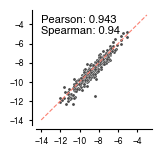

In [10]:
df_all = df_syn.merge(df_endo,on='barcode')
fig, axs = plt.subplots(1,1,figsize=(1.5,1.5),sharey=False,sharex=False)
sample = [('ratio_all_x','ratio_all_y')]
for i in range(1):
    s=sample[0]
    sns.scatterplot(x=s[0],y=s[1],data = df_all, color=['#4A4A4A'],s=5,marker='o',ax=axs)
    pr = sp.stats.pearsonr(df_all[s[0]],df_all[s[1]])[0]      
    sr = sp.stats.spearmanr(df_all[s[0]],df_all[s[1]])[0]      
    sns.despine(offset=3)
    start, end = -14,-3
    axs.yaxis.set_ticks(np.arange(start, end, 2))
    axs.xaxis.set_ticks(np.arange(start, end, 2))
    axs.text(-14,-5,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=8)
    axs.set_xlabel('')#s[0])
    axs.set_ylabel('')#s[1])
    axs.plot([start, end],[start, end],'--', color='#FB8072',linewidth=0.8)
    axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure2/figs/Supp_syn_endo_hek3_comp.pdf')

In [11]:
## Loading RNA sample
path = '../Figure2/300_enhancer/RT/'
designs = pd.read_table('../Figure2/300_enhancer/Enhancer_designs.txt',header=0).iloc[:,2:]
samples =['300_enhancer_RT_rep1','300_enhancer_RT_rep2','300_enhancer_RT_rep3']
with open(path+'300_enhancer_RT_rep1_bc_count.txt','r') as f:
    temp = f.readlines()
    rep1=pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if a[1]>5 and len(a[0])==6]),columns=['barcode','count'])

with open(path+'300_enhancer_RT_rep2_bc_count.txt','r') as f:
    temp = f.readlines()
    rep2=pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if a[1]>5 and len(a[0])==6]),columns=['barcode','count'])

with open(path+'300_enhancer_RT_rep3_bc_count.txt','r') as f:
    temp = f.readlines()
    rep3=pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if a[1]>5 and len(a[0])==6]),columns=['barcode','count'])

df_rna = rep1.merge(rep2,on='barcode',how='left').merge(rep3,on='barcode',how='left').fillna(0)
df_rna['barcode'] = df_rna['barcode'].apply(reverse_complement)
df_rna = df_rna.merge(designs['barcode'],how='right')
df_rna.columns = ['barcode','RNA_rep1','RNA_rep2','RNA_rep3']

df_all = df_syn.merge(df_rna,on='barcode',how='left')
df_all['ratio_rep1'] =  np.log2((df_all['ins_rep1']+1)/(df_all['ins_rep1'].sum()+1))#
df_all['ratio_rep2'] =  np.log2((df_all['ins_rep2']+1)/(df_all['ins_rep2'].sum()+1))#*10**6
df_all['ratio_rep3'] =  np.log2((df_all['ins_rep3']+1)/(df_all['ins_rep3'].sum()+1))#*10**6
df_all['ratio_all'] = np.log2((df_all['ins_rep1']+df_all['ins_rep2']+df_all['ins_rep3']+1)/
                          (df_all['ins_rep1'].sum()+df_all['ins_rep2'].sum()+df_all['ins_rep3'].sum()+1))#*10**6

df_all['RNA_ratio_rep1'] =  np.log2((df_all['RNA_rep1']+1)/(df_all['RNA_rep1'].sum()+1))#*10**6
df_all['RNA_ratio_rep2'] =  np.log2((df_all['RNA_rep2']+1)/(df_all['RNA_rep2'].sum()+1))#*10**6
df_all['RNA_ratio_rep3'] =  np.log2((df_all['RNA_rep3']+1)/(df_all['RNA_rep3'].sum()+1))#*10**6
df_all['RNA_ratio_all'] = np.log2((df_all['RNA_rep1']+df_all['RNA_rep2']+df_all['RNA_rep3']+1)/
                          (df_all['RNA_rep1'].sum()+df_all['RNA_rep2'].sum()+df_all['RNA_rep3'].sum()+1))#*10**6

In [12]:
df_all['diff'] = df_all['RNA_ratio_all'] - df_all['ratio_all']
df_all = df_all.sort_values(by='RNA_ratio_all')

## Correlation

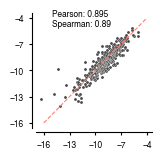

In [13]:
fig, axs = plt.subplots(figsize=(1.5,1.5),sharey=False,sharex=False)
s=['ratio_all','RNA_ratio_all']
sns.scatterplot(x='ratio_all',y='RNA_ratio_all',data = df_all, color=['#4A4A4A'],s=5,ax=axs)
sns.despine(offset=3)
axs.set_xlabel('Insertion ratio',fontsize=7);
axs.set_ylabel('RNA ratio',fontsize=7)
pr = sp.stats.pearsonr(df_all[s[0]],df_all[s[1]])[0]      
sr = sp.stats.spearmanr(df_all[s[0]],df_all[s[1]])[0]   
start, end = -16,-3.5
axs.yaxis.set_ticks(np.arange(start, end, 3))
axs.xaxis.set_ticks(np.arange(start, end, 3))
axs.text(-15,-5,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
axs.set_xlabel('')
axs.set_ylabel('')#s[1])
axs.plot([start, -4],[start, -4],'--',color='#FB8072',linewidth=0.8)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure2/figs/Figure-2C_MPRA_ENGRAM.pdf')

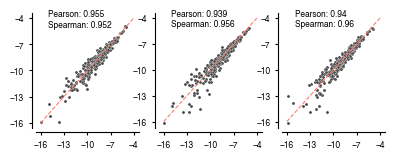

In [14]:
fig, axs = plt.subplots(1,3,figsize=(4.5,1.5),sharey=False,sharex=False)
sample = [('ratio_rep1','ratio_rep2'),('ratio_rep1','ratio_rep3'),('ratio_rep2','ratio_rep3')]
for i in range(3):
    s=sample[i]
    sns.scatterplot(x=s[0],y=s[1],data = df_all, color=['#4A4A4A'],s=5,ax=axs[i],marker='o')
    pr = sp.stats.pearsonr(df_all[s[0]],df_all[s[1]])[0]      
    sr = sp.stats.spearmanr(df_all[s[0]],df_all[s[1]])[0]        
    sns.despine(offset=3)
    start, end = -16,-3.5
    axs[i].yaxis.set_ticks(np.arange(start, end, 3))
    axs[i].xaxis.set_ticks(np.arange(start, end, 3))
    axs[i].text(-15,-5,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')#s[1])
    axs[i].plot([start, -4],[start, -4],'--',color='#FB8072',linewidth=0.8)
    axs[i].xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs[i].yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure2/figs/Supp_300_ENGRAM.pdf')

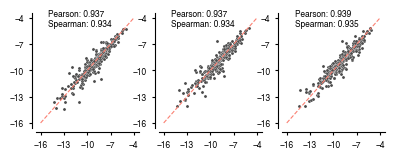

In [15]:
fig, axs = plt.subplots(1,3,figsize=(4.5,1.5),sharey=False,sharex=False)
sample = [('RNA_ratio_rep1','RNA_ratio_rep2'),('RNA_ratio_rep1','RNA_ratio_rep3'),('RNA_ratio_rep2','RNA_ratio_rep3')]

for i in range(3):
    s=sample[i]
    sns.scatterplot(x=s[0],y=s[1],data = df_all, color=['#4A4A4A'],s=5,ax=axs[i],marker='o')
    pr = sp.stats.pearsonr(df_all[s[0]],df_all[s[1]])[0]      
    sr = sp.stats.spearmanr(df_all[s[0]],df_all[s[1]])[0]        
    sns.despine(offset=3)
    start, end = -16,-3.5
    axs[i].yaxis.set_ticks(np.arange(start, end, 3))
    axs[i].xaxis.set_ticks(np.arange(start, end, 3))
    axs[i].text(-15,-5,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')#s[1])
    axs[i].plot([start, -4],[start, -4],'--',color='#FB8072',linewidth=0.8)
    axs[i].xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs[i].yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure2/figs/Supp_300_MPRA.pdf')

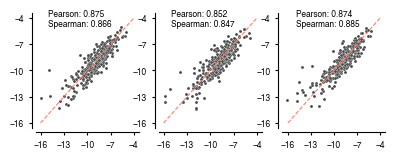

In [16]:
fig, axs = plt.subplots(1,3,figsize=(4.5,1.5),sharey=False,sharex=False)
sample = [('ratio_rep1','RNA_ratio_rep1'),('ratio_rep2','RNA_ratio_rep2'),('ratio_rep3','RNA_ratio_rep3')]
for i in range(3):
    s=sample[i]
    sns.scatterplot(x=s[0],y=s[1],data = df_all, color=['#4A4A4A'],s=5,ax=axs[i],marker='o')
    pr = sp.stats.pearsonr(df_all[s[0]],df_all[s[1]])[0]      
    sr = sp.stats.spearmanr(df_all[s[0]],df_all[s[1]])[0]        
    sns.despine(offset=3)
    start, end = -16,-3.5
    axs[i].yaxis.set_ticks(np.arange(start, end, 3))
    axs[i].xaxis.set_ticks(np.arange(start, end, 3))
    axs[i].text(-15,-5,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')#s[1])
    axs[i].plot([start, -4],[start, -4],'--',color='#FB8072',linewidth=0.8)
    axs[i].xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs[i].yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure2/figs/Supp_300_ENGRAM_MPRA.pdf')

## Rank & Quartile

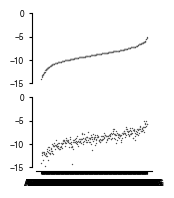

In [17]:
fig, axs = plt.subplots(2,1,figsize=(1.5,2),sharey=True,sharex=True)
sns.scatterplot(data=df_all, x='barcode', y='RNA_ratio_all',color=['#4A4A4A'], s=1,ax=axs[0])
sns.scatterplot(data=df_all, x='barcode', y='ratio_all',color=['#4A4A4A'], s=1,ax=axs[1])

sns.despine(offset=3,ax=axs[0])
sns.despine(offset=3,ax=axs[1])
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[0].set_ylim(-15,0)
axs[1].set_ylim(-15,0)
axs[0].xaxis.set_tick_params(width=0.8, length=0,labelsize=6)
axs[0].yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs[1].xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs[1].yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs[0].spines['bottom'].set_visible(False)
    
#plt.savefig('../Figure2/figs/Figure-2D_300_all_plot.pdf')

In [18]:
first_qt,second_qt,thirt_qt = -11, -9, -7 
np.random.seed(111)

q1 = df_all[df_all['RNA_ratio_all']<first_qt].sample(8)
q2 = df_all[(df_all['RNA_ratio_all']>first_qt) & (df_all['RNA_ratio_all']<second_qt)].sample(8)
q3 = df_all[(df_all['RNA_ratio_all']>second_qt) & (df_all['RNA_ratio_all']<thirt_qt)].sample(8)
q4 = df_all[df_all['RNA_ratio_all']>thirt_qt].sample(8)


q1['r1'] = q1['ratio_all'].rank()
q1['r2'] = q1['RNA_ratio_all'].rank()
q2['r1'] = q2['ratio_all'].rank()
q2['r2'] = q2['RNA_ratio_all'].rank()
q3['r1'] = q3['ratio_all'].rank()
q3['r2'] = q3['RNA_ratio_all'].rank()
q4['r1'] = q4['ratio_all'].rank()
q4['r2'] = q4['RNA_ratio_all'].rank()

q1 = q1.sort_values(by='RNA_ratio_all')
q2 = q2.sort_values(by='RNA_ratio_all')
q3 = q3.sort_values(by='RNA_ratio_all')
q4 = q4.sort_values(by='RNA_ratio_all')

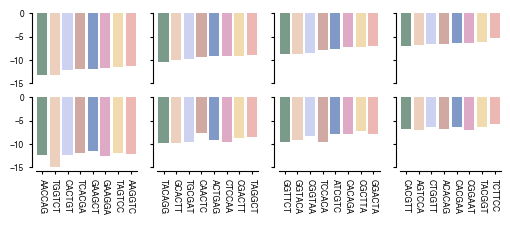

In [19]:
quat = [q1,q2,q3,q4]
fig, axs = plt.subplots(2,4,figsize=(6,2),sharey=True,sharex=False)
for i in range(4):
    q=quat[i]
    sns.barplot(data=q, x='barcode', y='RNA_ratio_all',ax=axs[0,i],palette=['#76A08A','#F5CDB6','#C7CEF6','#D8A49B','#7496D2','#E6A2C5','#FDDDA4','#F7B0AA'])
    sns.barplot(data=q, x='barcode', y='ratio_all',ax=axs[1,i],palette=['#76A08A','#F5CDB6','#C7CEF6','#D8A49B','#7496D2','#E6A2C5','#FDDDA4','#F7B0AA'])
    sns.despine(offset=3,ax=axs[0,i])
    sns.despine(offset=3,ax=axs[1,i])
    axs[0,i].set_xlabel('')
    axs[0,i].set_ylabel('')#s[1])
    axs[1,i].set_xlabel('')#s[1])
    axs[1,i].set_ylabel('')#s[1])
    axs[0,i].set_ylim(-15,0)
    axs[1,i].set_ylim(-15,0)
    axs[0,i].xaxis.set_tick_params(width=0.8, length=0,labelsize=6)
    axs[0,i].yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs[1,i].xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs[1,i].yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs[0,i].spines['bottom'].set_visible(False)
    axs[0,i].set_xticklabels([],rotation=-90)
    axs[1,i].set_xticklabels(axs[1,i].get_xticklabels(),rotation=-90)
    
#plt.savefig('../Figure2/figs/Supp_300_quant_barplot.pdf')

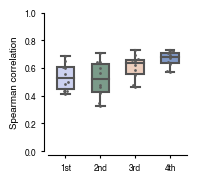

In [20]:
np.random.seed(111)
spear = []
condition = [(df_all['RNA_ratio_all']<first_qt),\
             ((df_all['RNA_ratio_all']>first_qt) & (df_all['RNA_ratio_all']<second_qt)),\
             ((df_all['RNA_ratio_all']>second_qt) & (df_all['RNA_ratio_all']<thirt_qt)),\
             df_all['RNA_ratio_all']>thirt_qt]
for quat in range(4):
    temp = []
    for i in range(10):
        q = df_all[condition[quat]].sample(20)
        q['r1'] = q['ratio_all'].rank()
        q['r2'] = q['RNA_ratio_all'].rank()
        temp.append(sp.stats.spearmanr(q['ratio_all'],q['RNA_ratio_all'])[0])
    spear.append(temp)
df_quart = pd.DataFrame(spear).T
df_quart.columns = ['1st','2nd','3rd','4th']
df_quart_melt = df_quart.melt()
fig, axs = fig, axs = plt.subplots(1,1,figsize=(1.8,1.8),sharey=False,sharex=False)
sns.boxplot(data=df_quart_melt,y='value',x='variable',palette=['#C7CEF6', '#76A08A', '#F5CDB6', '#7496D2'], width=0.5,showfliers=False)
sns.swarmplot(data=df_quart_melt,y='value',x='variable',s=2,color='#5C5C5C')
sns.despine(offset=3)
axs.set_ylabel('Spearman correlation',fontsize=7);
axs.set_xlabel('')
axs.set_ylim(0,1)

axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure2/figs/Supp_300_enhancer_ranking.pdf')

In [21]:
groups = ['1st','2nd','3rd','4th']
for a in itertools.combinations(groups,2):
    print (a,sp.stats.ttest_ind(df_quart[a[0]],df_quart[a[1]], equal_var=True))

('1st', '2nd') Ttest_indResult(statistic=0.33052567024233187, pvalue=0.744818991435474)
('1st', '3rd') Ttest_indResult(statistic=-1.75407756259596, pvalue=0.09642675826975025)
('1st', '4th') Ttest_indResult(statistic=-3.597451033007461, pvalue=0.0020588397711514645)
('2nd', '3rd') Ttest_indResult(statistic=-1.7911457031510543, pvalue=0.09010073243253126)
('2nd', '4th') Ttest_indResult(statistic=-3.199861655102291, pvalue=0.004963999427239386)
('3rd', '4th') Ttest_indResult(statistic=-1.6567962633176854, pvalue=0.11488787317042554)


## Sample input test

In [22]:
# Loading endogenous hek3 locus
path = '../Figure2/300_enhancer/Hek3/'
cells = ['1X','2X','4X','8X','16X']
cell_number = {'1X':6000,'2X':12000,'4X':6000*4,'8X':6000*8,'16X':6000*16}
sample_count_table = []
for k in range(5):
    df_new = pd.read_table('../Figure2/300_enhancer/Enhancer_designs.txt',header=0).iloc[:,2:]
    samples =sorted([s.split('_S')[0] for s in os.listdir(path) if '.gz' in s and 'R1' in s if cells[k] in s])
    for i in range(3):
        with open(path+samples[i]+'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==6]),columns=['barcode','count'])
            #test['barcode'] = test['barcode'].apply(reverse_complement)
            df_new = df_new.merge(test,on='barcode',how='left').fillna(0)
        f.close()
    df_new.columns = ['barcode','RNA/DNA ratio','ins_rep1','ins_rep2','ins_rep3']
    df_new['ratio_rep1'] =  np.log2((df_new['ins_rep1']+1)/(df_new['ins_rep1'].sum()+1))#
    df_new['ratio_rep2'] =  np.log2((df_new['ins_rep2']+1)/(df_new['ins_rep2'].sum()+1))#*10**6
    df_new['ratio_rep3'] =  np.log2((df_new['ins_rep3']+1)/(df_new['ins_rep3'].sum()+1))#*10**6
    df_new['ratio_all'] = np.log2((df_new['ins_rep1']+df_new['ins_rep2']+df_new['ins_rep3']+1)/
                          (df_new['ins_rep1'].sum()+df_new['ins_rep2'].sum()+df_new['ins_rep3'].sum()+1))#*10**6
    sample_count_table.append([cell_number[cells[k]],sum(df_new['ins_rep1']!=0),sum(df_new['ins_rep2']!=0),sum(df_new['ins_rep2']!=0),sp.stats.pearsonr(df_new['ratio_rep1'],df_new['ratio_rep2'])[0], sp.stats.pearsonr(df_new['ratio_rep1'],df_new['ratio_rep3'])[0],\
                 sp.stats.pearsonr(df_new['ratio_rep3'],df_new['ratio_rep2'])[0]])
sample_count_table = pd.DataFrame(sample_count_table,columns=['sample','recovery','recovery','recovery','PR','PR','PR'])

In [23]:
# Loading synthetic Hek3 locus
path = '../Figure2/300_enhancer/synHek3/'
cells = ['1X','2X','4X','8X','16X']
cell_number = {'1X':6000,'2X':12000,'4X':6000*4,'8X':6000*8,'16X':6000*16}
sample_count_table_tape = []
for k in range(5):
    df_new = pd.read_table('../Figure2/300_enhancer/Enhancer_designs.txt',header=0).iloc[:,2:]
    samples =sorted([s.split('_S')[0] for s in os.listdir(path) if '.gz' in s and 'R1' in s if cells[k] in s])
    for i in range(3):
        with open(path+samples[i]+'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==6]),columns=['barcode','count'])
            test['barcode'] = test['barcode'].apply(reverse_complement)
            df_new = df_new.merge(test,on='barcode',how='left').fillna(0)
        f.close()
    df_new.columns = ['barcode','RNA/DNA ratio','ins_rep1','ins_rep2','ins_rep3']
    df_new['ratio_rep1'] =  np.log2((df_new['ins_rep1']+1)/(df_new['ins_rep1'].sum()+1))#
    df_new['ratio_rep2'] =  np.log2((df_new['ins_rep2']+1)/(df_new['ins_rep2'].sum()+1))#*10**6
    df_new['ratio_rep3'] =  np.log2((df_new['ins_rep3']+1)/(df_new['ins_rep3'].sum()+1))#*10**6
    df_new['ratio_all']  =  np.log2((df_new['ins_rep1']+df_new['ins_rep2']+df_new['ins_rep3']+1)/(df_new['ins_rep1'].sum()+df_new['ins_rep2'].sum()+df_new['ins_rep3'].sum()+1))#*10**6
    sample_count_table_tape.append([cell_number[cells[k]],sum(df_new['ins_rep1']!=0),sum(df_new['ins_rep2']!=0),sum(df_new['ins_rep2']!=0),sp.stats.pearsonr(df_new['ratio_rep1'],df_new['ratio_rep2'])[0], sp.stats.pearsonr(df_new['ratio_rep1'],df_new['ratio_rep3'])[0],\
                 sp.stats.pearsonr(df_new['ratio_rep3'],df_new['ratio_rep2'])[0]])
sample_count_table_tape = pd.DataFrame(sample_count_table_tape,columns=['sample','recovery','recovery','recovery','PR','PR','PR'])

In [24]:
sample_count = pd.merge(sample_count_table,sample_count_table_tape,on='sample')
df1 = sample_count.iloc[:,[0,1,2,3,7,8,9]].melt(id_vars='sample')
df2 = sample_count.iloc[:,[0,4,5,6,10,11,12]].melt(id_vars='sample')
df1['sample'] = pd.Categorical(df1['sample'],
                             categories=[6000,12000,24000,48000,96000],ordered=True) #['D1','D3','D5','D7','D9','D11','D13','D15','D17','D21']
df2['sample'] = pd.Categorical(df2['sample'],
                             categories=[6000,12000,24000,48000,96000],ordered=True) #['D1','D3','D5','D7','D9','D11','D13','D15','D17','D21']

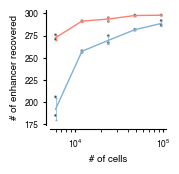

In [25]:
fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
g=sns.lineplot(data=df1,x="sample", y="value",hue='variable',palette=['#80B1D3','#FB8072'],\
               linewidth = 1,markers=['o','.'],markersize=2,dashes=False,err_style="bars", err_kws={'capsize':1,'elinewidth':0.5},errorbar='sd',ax=axs)
sns.scatterplot(data=df1, x="sample", y="value", color="#4A4A4A",marker='.',size=4,ax=axs)

axs.set_xlabel('# of cells',fontsize=7);
axs.set_ylabel('# of enhancer recovered',fontsize=7)
axs.set_xscale('log',base=10)

axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
g.legend_.remove()
sns.despine(offset=3)
#plt.savefig('../Figure2/figs/Supp_syn_endo_recover.pdf')

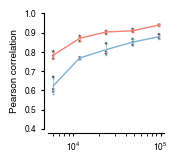

In [26]:
fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
g=sns.lineplot(data=df2,x="sample", y="value",hue='variable', palette=['#80B1D3','#FB8072'],\
               linewidth = 1,markers=['X','.'],dashes=False,err_style="bars", err_kws={'capsize':1,'elinewidth':0.5},errorbar='sd',ax=axs)
sns.scatterplot(data=df2, x="sample", y="value", color="#4A4A4A",marker='.',size=4,ax=axs)

axs.set_xlabel('');
axs.set_xscale('log',base=10)
axs.set_ylabel('Pearson correlation',fontsize=7)
axs.set_ylim(0.4,1)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
g.legend_.remove()
sns.despine(offset=3)
#plt.savefig('../Figure2/figs/Supp_syn_endo_pr.pdf')

## Sequencing depth test

In [27]:
path = '../Figure2/300_enhancer/seq_reads_downsample/'
cells = ['4M','1M','250k','50k']
sample_count_table_tape = []
for k in range(4):
    df_new = pd.read_table('../Figure2/300_enhancer/Enhancer_designs.txt',header=0).iloc[:,2:]
    samples = sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and cells[k] in s])
    for i in range(3):
        with open(path+samples[i]+'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==6]),columns=['barcode','count'])
            test['barcode'] = test['barcode'].apply(reverse_complement)
            df_new = df_new.merge(test,on='barcode',how='left').fillna(0)
        f.close()
    df_new.columns = ['barcode','RNA/DNA ratio','ins_rep1','ins_rep2','ins_rep3']
    df_new['ratio_rep1'] =  np.log2((df_new['ins_rep1']+1)/(df_new['ins_rep1'].sum()+1))#
    df_new['ratio_rep2'] =  np.log2((df_new['ins_rep2']+1)/(df_new['ins_rep2'].sum()+1))#*10**6
    df_new['ratio_rep3'] =  np.log2((df_new['ins_rep3']+1)/(df_new['ins_rep3'].sum()+1))#*10**6
    df_new['ratio_all'] = np.log2((df_new['ins_rep1']+df_new['ins_rep2']+df_new['ins_rep3']+1)/
                          (df_new['ins_rep1'].sum()+df_new['ins_rep2'].sum()+df_new['ins_rep3'].sum()+1))#*10**6
    sample_count_table_tape.append([cells[k],sum(df_new['ins_rep1']!=0),sum(df_new['ins_rep2']!=0),sum(df_new['ins_rep2']!=0),sp.stats.pearsonr(df_new['ratio_rep1'],df_new['ratio_rep2'])[0], sp.stats.pearsonr(df_new['ratio_rep1'],df_new['ratio_rep3'])[0],\
                 sp.stats.pearsonr(df_new['ratio_rep3'],df_new['ratio_rep2'])[0]])
sample_count_table_tape = pd.DataFrame(sample_count_table_tape,columns=['sample','recovery','recovery','recovery','PR','PR','PR'])

In [28]:
df1 = sample_count_table_tape.iloc[:,[0,1,2,3]].melt(id_vars='sample')
df2 = sample_count_table_tape.iloc[:,[0,4,5,6]].melt(id_vars='sample')
df1['sample'] = pd.Categorical(df1['sample'],categories=['50k','250k','1M','4M']) 
df2['sample'] = pd.Categorical(df2['sample'],categories=['50k','250k','1M','4M']) 

In [29]:
order=['50k','250k','1M','4M'],

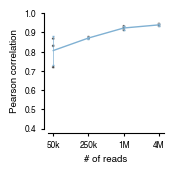

In [30]:
fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
g=sns.lineplot(data=df2,x="sample", y="value", color='#80B1D3',\
               linewidth = 1,markers=['X','.'],dashes=False,err_style="bars", err_kws={'capsize':1,'elinewidth':0.5},errorbar='sd',ax=axs)
sns.scatterplot(data=df2, x="sample", y="value", color="#4A4A4A",marker='.',size=4,ax=axs)
axs.set_xlabel('# of reads',fontsize=7);
axs.set_ylabel('Pearson correlation',fontsize=7)
axs.set_ylim(0.4,1)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
g.legend_.remove()
sns.despine(offset=3)
#plt.savefig('../Figure2/figs/Supp_300_enhancer_read_downsample_pearson.pdf')

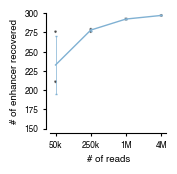

In [31]:
fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
g=sns.lineplot(data=df1,x="sample", y="value", color='#80B1D3',\
               linewidth = 1,markers=['X','.'],dashes=False,err_style="bars", err_kws={'capsize':1,'elinewidth':0.5},errorbar='sd',ax=axs)
sns.scatterplot(data=df1, x="sample", y="value", color="#4A4A4A",marker='.',size=4,ax=axs)
axs.set_ylim(150,300);
axs.set_xlabel('# of reads',fontsize=7);
axs.set_ylabel('# of enhancer recovered',fontsize=7)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
g.legend_.remove()
sns.despine(offset=3)
#plt.savefig('../Figure2/figs/Supp_300_enhancer_read_downsample_recovery.pdf')

## RT downsample

In [32]:
path = '../Figure2/300_enhancer/RT/'
cells = ['80K','20K','5K','1K']
sample_count_RNA = []
for k in range(4):
    df_new = pd.read_table('../Figure2/300_enhancer/Enhancer_designs.txt',header=0).iloc[:,2:]
    samples = sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and cells[k] in s])
    for i in range(3):
        with open(path+samples[i]+'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==6]),columns=['barcode','count'])
            test['barcode'] = test['barcode'].apply(reverse_complement)
            df_new = df_new.merge(test,on='barcode',how='left').fillna(0)
        f.close()
    df_new.columns = ['barcode','RNA/DNA ratio','ins_rep1','ins_rep2','ins_rep3']
    df_new['ratio_rep1'] =  np.log2((df_new['ins_rep1']+1)/(df_new['ins_rep1'].sum()+1))#
    df_new['ratio_rep2'] =  np.log2((df_new['ins_rep2']+1)/(df_new['ins_rep2'].sum()+1))#*10**6
    df_new['ratio_rep3'] =  np.log2((df_new['ins_rep3']+1)/(df_new['ins_rep3'].sum()+1))#*10**6
    df_new['ratio_all'] = np.log2((df_new['ins_rep1']+df_new['ins_rep2']+df_new['ins_rep3']+1)/
                                  (df_new['ins_rep1'].sum()+df_new['ins_rep2'].sum()+df_new['ins_rep3'].sum()+1))#*10**6
    sample_count_RNA.append([cells[k],sum(df_new['ins_rep1']!=0),sum(df_new['ins_rep2']!=0),sum(df_new['ins_rep2']!=0),sp.stats.pearsonr(df_new['ratio_rep1'],df_new['ratio_rep2'])[0], sp.stats.pearsonr(df_new['ratio_rep1'],df_new['ratio_rep3'])[0],\
                 sp.stats.pearsonr(df_new['ratio_rep3'],df_new['ratio_rep2'])[0]])
sample_count_RNA = pd.DataFrame(sample_count_RNA,columns=['sample','recovery','recovery','recovery','PR','PR','PR'])

In [33]:
sample_count_RNA

,sample,recovery,recovery,recovery,PR,PR,PR
0,80K,298,298,298,0.913411,0.932230,0.922992
1,20K,295,295,295,0.899582,0.905668,0.908280
2,5K,274,275,275,0.798490,0.821656,0.833137
3,1K,215,198,198,0.597507,0.655587,0.652909


In [34]:
df1 = sample_count_RNA.iloc[:,[0,1,2,3]].melt(id_vars='sample')
df2 = sample_count_RNA.iloc[:,[0,4,5,6]].melt(id_vars='sample')
df1['sample'] = pd.Categorical(df1['sample'],categories=['1K','5K','20K','80K']) 
df2['sample'] = pd.Categorical(df2['sample'],categories=['1K','5K','20K','80K']) 

In [35]:
order=['1K','5K','20K','80K']

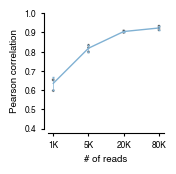

In [36]:
fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
g=sns.lineplot(data=df2,x="sample", y="value", color='#80B1D3',\
               linewidth = 1,markers=['X','.'],dashes=False,err_style="bars", err_kws={'capsize':1,'elinewidth':0.5},errorbar='sd',ax=axs)
sns.scatterplot(data=df2, x="sample", y="value", color="#4A4A4A",marker='.',size=4,ax=axs)
axs.set_xlabel('# of reads',fontsize=7);
axs.set_ylabel('Pearson correlation',fontsize=7)
axs.set_ylim(0.4,1)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
g.legend_.remove()
sns.despine(offset=3)
#plt.savefig('../Figure2/figs/Supp_300_enhancer_RT_read_downsample_pearson.pdf')

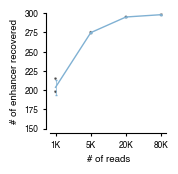

In [37]:
fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
g=sns.lineplot(data=df1,x="sample", y="value", color='#80B1D3',\
               linewidth = 1,markers=['X','.'],dashes=False,err_style="bars", err_kws={'capsize':1,'elinewidth':0.5},errorbar='sd',ax=axs)
sns.scatterplot(data=df1, x="sample", y="value", color="#4A4A4A",marker='.',size=4,ax=axs)
axs.set_ylim(150,300);
axs.set_xlabel('# of reads',fontsize=7);
axs.set_ylabel('# of enhancer recovered',fontsize=7)
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
g.legend_.remove()
sns.despine(offset=3)
#plt.savefig('../Figure2/figs/Supp_300_enhancer_RT_read_downsample_recovery.pdf')

# Figure 2 f-g SynEnhancer cell specific test

In [38]:
path = '../Figure2/synEN/'
samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if 'HEK293T' in s and '.tsv' in s])
df_hek = pd.read_table(path+'synEn_designs.txt')
for i in range(3):
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5] ),columns=['barcode','count'])
        test['count'] = test['count']
        df_hek=df_hek.merge(test,on='barcode',how='inner').fillna(0)
df_hek.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2','Hek293_rep3']

In [39]:
samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if 'K562' in s and '.tsv' in s])
df_k562 = pd.read_table(path+'synEn_designs.txt')
for i in range(3):
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5]),columns=['barcode','count'])
        test['count'] = test['count']
        df_k562=df_k562.merge(test,on='barcode',how='inner').fillna(0)
df_k562.columns =  ['motif','barcode','barcode_rc','Sequence','K562_rep1','K562_rep2','K562_rep3']

In [40]:
df_hek['Hek_ratio_rep1'] =  np.log2((df_hek['Hek293_rep1'])/(df_hek['Hek293_rep1'].sum()))#*10**6
df_hek['Hek_ratio_rep2'] =  np.log2((df_hek['Hek293_rep2'])/(df_hek['Hek293_rep2'].sum()))#*10**6
df_hek['Hek_ratio_rep3'] =  np.log2((df_hek['Hek293_rep3'])/(df_hek['Hek293_rep3'].sum()))#*10**6
df_k562['K562_ratio_rep1'] =  np.log2((df_k562['K562_rep1'])/(df_k562['K562_rep1'].sum()))#*10**6
df_k562['K562_ratio_rep2'] =  np.log2((df_k562['K562_rep2'])/(df_k562['K562_rep2'].sum()))#*10**6
df_k562['K562_ratio_rep3'] =  np.log2((df_k562['K562_rep3'])/(df_k562['K562_rep3'].sum()))#*10**6

## Insertion betwee
df_k562['K562_ratio'] = np.log2((df_k562['K562_rep1']+df_k562['K562_rep2']+df_k562['K562_rep3'])/
                          (df_k562['K562_rep1'].sum()+df_k562['K562_rep2'].sum()+df_k562['K562_rep3'].sum()))
df_hek['Hek293_ratio'] = np.log2((df_hek['Hek293_rep1']+df_hek['Hek293_rep2']+df_hek['Hek293_rep3'])/
                          (df_hek['Hek293_rep1'].sum()+df_hek['Hek293_rep2'].sum()+df_hek['Hek293_rep3'].sum()))

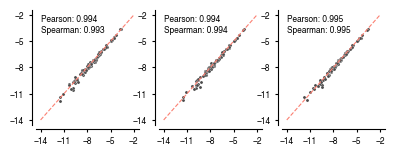

In [41]:
fig, axs = plt.subplots(1,3,figsize=(4.5,1.5),sharey=False,sharex=False)
sample = [('Hek_ratio_rep1','Hek_ratio_rep2'),('Hek_ratio_rep1','Hek_ratio_rep3'),('Hek_ratio_rep2','Hek_ratio_rep3')]
for i in range(3):
    s=sample[i]
    sns.scatterplot(x=s[0],y=s[1],data = df_hek, color=['#4A4A4A'],s=5,ax=axs[i],marker='o')
    pr = sp.stats.pearsonr(df_hek[s[0]],df_hek[s[1]])[0]
    sr = sp.stats.spearmanr(df_hek[s[0]],df_hek[s[1]])[0]
    sns.despine(offset=3)
    start, end = -14,0
    axs[i].yaxis.set_ticks(np.arange(start, end, 3))
    axs[i].xaxis.set_ticks(np.arange(start, end, 3))
    axs[i].text(-14,-4,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')#s[1])
    axs[i].plot([start, -2],[start, -2],'--',color='#FB8072',linewidth=0.8)
    axs[i].xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs[i].yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure2/figs/supp_synEn_hek.pdf')

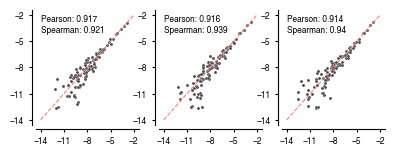

In [42]:
fig, axs = plt.subplots(1,3,figsize=(4.5,1.5),sharey=False,sharex=False)
sample = [('K562_ratio_rep1','K562_ratio_rep2'),('K562_ratio_rep1','K562_ratio_rep3'),('K562_ratio_rep2','K562_ratio_rep3')]
for i in range(3):
    s=sample[i]
    sns.scatterplot(x=s[0],y=s[1],data = df_k562, color=['#4A4A4A'],s=5,ax=axs[i],marker='o')
    pr = sp.stats.pearsonr(df_k562[s[0]],df_k562[s[1]])[0] 
    sr = sp.stats.spearmanr(df_k562[s[0]],df_k562[s[1]])[0]
    sns.despine(offset=3)
    start, end = -14,0
    axs[i].yaxis.set_ticks(np.arange(start, end, 3))
    axs[i].xaxis.set_ticks(np.arange(start, end, 3))
    axs[i].text(-14,-4,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')#s[1])
    axs[i].plot([start, -2],[start, -2],'--',color='#FB8072',linewidth=0.8)
    axs[i].xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs[i].yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure2/figs/supp_synEn_K562.pdf')

### DESEQ2
Run in R kernel

In [1]:
suppressPackageStartupMessages({
  options(stringsAsFactors = FALSE)
  library(DESeq2);
  library(data.table);
  library(gdata);
  library(BSgenome);
  library(ggplot2);
  library(RColorBrewer);
  library(biomaRt);
  library(ggrepel);
  library(tidyverse)})

In [23]:
design <- as.matrix(read.csv('../Figure5/98_TF_motif_designs.csv',sep=',',header=TRUE,check.names = FALSE))
design_new = data.frame(design[,c(1,2,5,6,7,8)])
cts <- as.matrix(read.csv("../Figure5/mESC_hek_k562_comparison_deseq.csv", sep = ",", row.names='barcode', header = T))
keep <- rowSums(cts) >= 1000
cts <- cts[keep,]
coldata <- read.csv("../Figure5/coldata_mESC_Hek293T_K562.csv", sep = ",", row.names='X0')
rownames(coldata) <- gsub("-", ".", rownames(coldata))
colnames(coldata) <- c('condition')

In [ ]:
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData   = coldata,
                              design    = ~ condition)
dds <- DESeq(dds)

In [ ]:
res_unshrunken <- results(dds, contrast=c("condition","K562","Hek293"), alpha = 0.05, lfcThreshold = 1)
res <- lfcShrink(dds, coef='condition_K562_vs_Hek293', res=res_unshrunken)

res$rowname <- rownames(res)
res_final <- res %>%
  data.frame() %>% 
  as_tibble()%>% arrange(padj)%>% mutate(threshold = padj < 1e-3)
res_final <- merge(res_final,design_new,by.x='rowname',by.y='barcode')%>% arrange(padj)
#res_final[0:50,]

In [ ]:
pdf(file = "../Figure2/figs/Fig2g_syn_rec_des_hek293_vs_k562.pdf",   # The directory you want to save the file in
    width = 2, # The width of the plot in inches
    height = 1.5) # The height of the plot in inches
p1 <- ggplot(res_final, aes(x = log2FoldChange, y = -log10(padj))) +
        geom_point(aes(colour = threshold),size=1 ) + 
        scale_color_manual(values=c("#5C5C5C", "#FB8072"))+
        xlab("") + 
        ylab("") + 
        scale_x_continuous(limits = c(-4,4))+
        scale_y_continuous(limits = c(0., 65))+ 
        theme_classic() + 
        theme(legend.position="none",
              axis.text = element_text(size = 6),
              axis.title = element_text(size = 7),
              axis.ticks.length=unit(2,"pt"),
              axis.ticks = element_line(size=72.27/96*0.5),
              axis.line = element_line(color="black", size = 72.27/96*0.5))
p1
dev.off()

## Overall editing efficiency

In [43]:
path = '../Figure2/synEN/'
## Use the sequence in pegRNA not in gDNA so need to reverse complement
samples =sorted([s.split('.fastq')[0] for s in os.listdir(path) if '.gz' in s])

edits = []
for s in samples:
    file = path+s
    #rcount = int(read_count[read_count['sample'].str.contains(s)]['counts'])
    with open(file +'_bc_count.tsv','r') as f:
        temp = f.readlines()
        count_table = np.array([a for a in [str2array(s) for s in temp]if len(a[0])==5 or a[0]==''],dtype=object)
        ratio = sum(count_table[1:,1])/sum(count_table[:,1])
    f.close()
    a,rep = s.split('_rep')
    
    b = a.split('-')
    edits.append([b[0],'rep'+rep,ratio*100])
df = pd.DataFrame(edits,columns=['Designs','rep','Editing efficiency'])

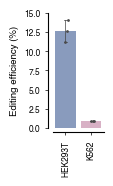

In [45]:
fig, axs = plt.subplots(figsize=(1.5,1.5),sharey=False,sharex=False)
g=sns.barplot(data=df, x="Designs", y='Editing efficiency',palette=['#8099C6','#DEABC5'],errwidth=0.5, errorbar='sd', capsize=.1) #['#D0A9A3','#EDB8B4']
sns.stripplot(data=df, x="Designs", y='Editing efficiency',dodge=True,color="#4A4A4A",marker='.',size=4,ax=axs)
axs.set_xlabel('');
axs.set_ylim(0,15);
g.set_box_aspect(4.5/len(g.patches))
start, end = axs.get_ylim()
axs.set_ylabel('Editing efficiency (%)',fontsize=7)
axs.xaxis.set_tick_params(width=0.5, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.5, length=2,labelsize=6)
sns.despine(offset=3)
for tick in axs.get_xticklabels():
    tick.set_rotation(90)
#plt.savefig('../Figure2/figs/supp_syn_edit_eff.pdf')

## Plot gene exp diff in two cell lines

In [46]:
k562 = pd.read_table( '../Figure2/synEN/K562_exp.txt',header=None,sep='\t')
hek = pd.read_table( '../Figure2/synEN/293_exp.txt',header=None,sep='\t')
df = k562.iloc[:,[1,5]].merge(hek.iloc[:,[1,5]],on=1,how='inner')
df.columns=['gene','K562_nTPM','HEK_nTPM']

In [47]:
df_sub = df[(df['gene'].str.contains('BHLHE40|NFIL3|KLF1|POU2F1|POU2AF1|FOSL1|JUNB|ATF4|CEBPB|CEBPG|ETV5|NRF1|SOX2|ZNF449|NEUROG2|TP53|GCM2'))].reset_index(drop=True)
#stat = pd.concat((df[(df['gene'].str.contains('STAT5'))],df[(df['gene'].str.contains('STAT3'))])).sum()
stat = df[(df['gene'].str.contains('STAT5'))].sum()
stat['gene']='STAT5'
nfkb = pd.concat((df[(df['gene'].str.contains('NFKB1'))],df[(df['gene'].str.contains('NFKB2'))])).sum()
nfkb['gene']='NFKB'
df_sub = pd.concat([df_sub,pd.DataFrame(stat).T,pd.DataFrame(nfkb).T],ignore_index=True)
df_sub['K562_nTPM']=df_sub['K562_nTPM'].astype(float)
df_sub['HEK_nTPM']=df_sub['HEK_nTPM'].astype(float)
df_sub['K562_log2'] = np.log2(df_sub['K562_nTPM']+1)
df_sub['HEK_log2'] = np.log2(df_sub['HEK_nTPM']+1)
df_sub['diff']=df_sub['K562_log2']-df_sub['HEK_log2']
df_melt = df_sub.iloc[:,[0,5]].melt(id_vars='gene')

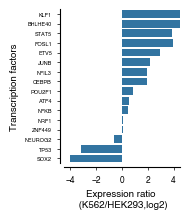

In [28]:
fig, axs = plt.subplots(1,figsize=(1.5,2),sharey=False,sharex=False)
g=sns.barplot(data = df_melt,x='value',y='gene',hue='variable',order=['KLF1','BHLHE40','STAT5','FOSL1','ETV5','JUNB','NFIL3','CEBPB','POU2F1','ATF4','NFKB','NRF1','ZNF449','NEUROG2','TP53','SOX2'],ax=axs)
axs.set_xlabel('');
axs.set_ylabel('Transcription factors',fontsize=7)
axs.set_xlabel('Expression ratio \n (K562/HEK293,log2)',fontsize=7)
axs.set_xlim(-4.5,4.5)
axs.set_xticks(np.arange(-4, 4.1, 2))
axs.xaxis.set_tick_params(width=0.5, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.5, length=2,labelsize=4)
axs.legend([],[], frameon=False)

sns.despine(offset=3)
#plt.savefig('../Figure2/figs/supp5d_gene_exp_diff.pdf')